In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from skopt import dummy_minimize, gp_minimize
from sklearn import preprocessing
from utils.functions import *
le = preprocessing.LabelEncoder()

In [3]:
base = pd.read_csv("./data/data_modelagem.csv")
base = base.drop(columns=['State', 'Unnamed: 0'])
base = base.rename(columns={'%_de_extremamente_pobres_':"%_ext_pob",'idhm_ajustado_à_desigualdade_':'idhm_desigualdade'})

<AxesSubplot:>

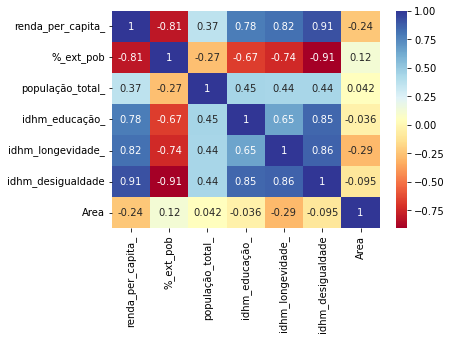

In [4]:
# Teria que ver se é mais coerente usar todas as observações, ou limitalas, 
# acabei deixando só com a base de treino 
# E aquelas montes de diagramas de dispersão acho bem desnecessário, 
# já que esse gráfico de correlação já nos mostra o essencial
# Mas daria pra fazer se for o caso
sns.heatmap(base.iloc[0:27, :].corr(), annot=True,cmap='RdYlBu')

<AxesSubplot:xlabel='%_ext_pob', ylabel='renda_per_capita_'>

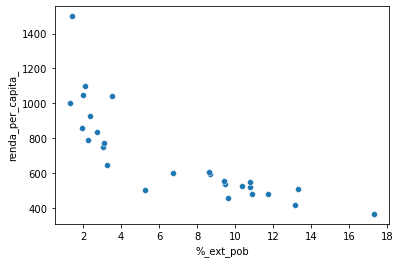

In [23]:
# sns.barplot(data=base.iloc[0:27, :], x='Region', y='renda_per_capita_')
# sns.scatterplot(x="%_ext_pob", y="renda_per_capita_", data=base.iloc[0:27, :])

<AxesSubplot:xlabel='Region', ylabel='renda_per_capita_'>

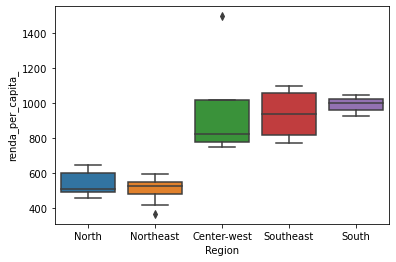

In [5]:
# Acredito que o boxplot fica melhor que barras, ja da para ver outliers alem da diferença de renda de cada regiao
sns.boxplot(x='Region', y='renda_per_capita_', data=base.iloc[0:27, :])

<AxesSubplot:xlabel='renda_per_capita_', ylabel='territorialidade'>

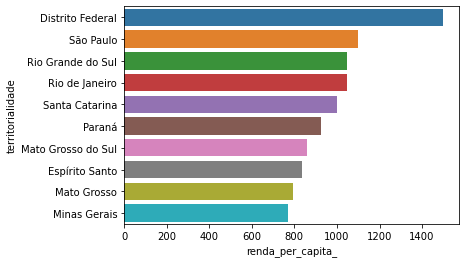

In [16]:
# Essa dos estados nã osei se tem necessidade, pq estamos lidando por região, isso daqui nem vai para a modelagem
sns.barplot(x='renda_per_capita_', 
            y="territorialidade", data=base.iloc[0:27, :],  
            order=base.iloc[0:27, :].sort_values('renda_per_capita_',ascending = False).territorialidade.iloc[0:10])

In [8]:
dummies = pd.get_dummies(base['Region'])
base[dummies.columns] = dummies

In [9]:
base = base.drop(columns=['Region','idhm_desigualdade'])

In [10]:
treino = base.iloc[0:27, :].drop(columns=['territorialidade'])
teste = base.iloc[27:54, :].drop(columns=['territorialidade'])
val = base.iloc[54:81, :].drop(columns=['territorialidade'])

In [11]:
y_treino = treino['renda_per_capita_']
y_teste = teste['renda_per_capita_']
y_val = val['renda_per_capita_']
treino = treino.drop(columns=['renda_per_capita_'])
teste = teste.drop(columns=['renda_per_capita_'])
val = val.drop(columns=['renda_per_capita_'])

In [12]:
def search_space(model):
    model = model.lower()
    space = {}
    if model == 'dt':
        space = {
            'min_samples_leaf': hp.randint('min_samples_leaf', 1,50),
            'max_depth': hp.randint('max_depth', 1,25),
            'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
            'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 1)
            }
    elif model == 'lasso':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 10),
            'warm_start' : hp.choice('warm_start', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000))
            }
    elif model == 'ridge':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 500),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            'solver' : hp.choice('solver', ['svd', 'sag', 'saga', 'lbfgs', 'auto']),
            }
    elif model == 'linear':
         space = {
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            }
    elif model == 'elastic':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 100),
            'l1_ratio' : hp.uniform('l1_ratio', 0, 1),
            'warm_start' : hp.choice('warm_start', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            }
    elif model == 'rf':
        space = {
                'min_samples_leaf': hp.randint('min_samples_leaf', 1,50),
                'max_depth': hp.randint('max_depth', 1,20),
                'n_estimators': hp.randint('n_estimators', 50,1000),
                'max_leaf_nodes' : hp.randint('max_leaf_nodes', 2,100),
                'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.3)
            }
    elif model == 'lgbm':
        space = {
            'num_leaves':  hp.randint('num_leaves', 1,50),
            'max_depth': hp.randint('max_depth', 1,20),
            'feature_fraction':  hp.uniform('feature_fraction', 0.2, 0.5),
            'subsample':  hp.uniform('subsample', 0.2, 1),
            'bagging_fraction':  hp.uniform('bagging_fraction', 0.5, 0.9),    
            'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
            'lambda_l1':  hp.uniform('lambda_l1', 0.0001, 1),
            'lambda_l2':  hp.uniform('lambda_l2', 0.0001, 1),
            'min_child_samples': hp.randint('min_child_samples', 1,50),
            'n_estimators': hp.randint('n_estimators', 50,1000),
            'colsample_bytree':  hp.uniform('colsample_bytree', 0.1, 1)  
            }
    elif model == 'xgb':
        space={
                'max_depth': hp.choice('max_depth', range(1,20)),
                'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
                'gamma': hp.uniform ('gamma', 1,9),
                'min_child_samples': hp.choice('min_child_samples', range(1,50)),
                'subsample':  hp.uniform('subsample', 0.2, 1),
                'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
                'reg_lambda' : hp.uniform('reg_lambda', 0,1),
                'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
                'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
                'n_estimators': hp.choice('n_estimators', range(50,1000)),
                'parallel_tree': hp.uniform ('parallel_tree', 1,10),
            }
    space['model'] = model
    return space

In [13]:
models = {
            'dt' : DecisionTreeRegressor,
            'rf' : RandomForestRegressor,
            'xgb' : XGBRegressor,
            'lgbm' : LGBMRegressor ,
            'lasso' : Lasso,
            'elastic' : ElasticNet,
            'ridge' : Ridge,
            'linear' : LinearRegression
        }

In [14]:
def get_acc_status(clf,X_,y):
    acc = cross_val_score(clf, X_, y, cv=5, scoring="neg_root_mean_squared_error").mean()
    display(clear=True)
    return {'loss': -acc, 'status': STATUS_OK}

def obj_fnc(params):
    print(type(params.get('model')), '---')
    model = params.get('model').lower()
    del params['model']
    clf = models[model](**params)
    display(clear=True)
    return(get_acc_status(clf,treino,y_treino))

In [156]:
best_params

{'cat': {}}

In [15]:
best_params = {}
hypopt_trials = {}

for model in models:
    hypopt_trials[model] = Trials()
    best_params[model] = fmin(obj_fnc, search_space(model), algo=tpe.suggest,
    max_evals=50, trials= hypopt_trials[model])
    print(best_params[model])
    print(hypopt_trials[model].best_trial['result']['loss'])

100%|██████████| 50/50 [00:01<00:00, 27.61trial/s, best loss: 162.11573972335447]
{'fit_intercept': 0}
162.11573972335447


In [18]:
for model in best_params:
    if model == 'rf':
        crit = {0: 'gini', 1:  'entropy', 2: 'log_loss'}
        feat = {0: 'sqrt', 1: 'log2', 2: None}

        trainedforest = RandomForestRegressor(
                                            min_samples_leaf = best_params[model]['min_samples_leaf'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            min_impurity_decrease = best_params[model]['min_impurity_decrease'], 
                                            max_leaf_nodes = best_params[model]['max_leaf_nodes'], 
                                            n_estimators = best_params[model]['n_estimators']
                                            ).fit(treino, y_treino)

    elif model == 'xgb':
         trainedxgb = XGBRegressor(learning_rate = best_params[model]['learning_rate'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            gamma = best_params[model]['gamma'],
                                            min_child_samples = best_params[model]['min_child_samples'],
                                            subsample = best_params[model]['subsample'], 
                                            reg_alpha = best_params[model]['reg_alpha'],
                                            reg_lambda = best_params[model]['reg_lambda'],
                                            colsample_bytree = best_params[model]['colsample_bytree'], 
                                            min_child_weight = best_params[model]['min_child_weight'], 
                                            parallel_tree = best_params[model]['parallel_tree'], 
                                            n_estimators = best_params[model]['n_estimators']
                                            ).fit(treino, y_treino)
    elif model == 'lgbm':
         trainedlgbm = LGBMRegressor(learning_rate = best_params[model]['learning_rate'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            num_leaves = best_params[model]['num_leaves'],
                                            subsample = best_params[model]['subsample'], 
                                            colsample_bytree = best_params[model]['colsample_bytree'], 
                                            feature_fraction = best_params[model]['feature_fraction'], 
                                            bagging_fraction = best_params[model]['bagging_fraction'], 
                                            n_estimators = best_params[model]['n_estimators'],
                                            lambda_l1 = best_params[model]['lambda_l1'],
                                            lambda_l2 = best_params[model]['lambda_l2'],
                                            min_child_samples = best_params[model]['min_child_samples']
                                            ).fit(treino, y_treino)

    elif model == 'dt':
        feat = {0: 'sqrt', 1: 'log2', 2: None}
        trainedtree = DecisionTreeRegressor(
                                            max_depth = best_params[model]['max_depth'], 
                                            max_features = feat[best_params[model]['max_features']], 
                                            min_samples_leaf = best_params[model]['min_samples_leaf'], 
                                            min_impurity_decrease = best_params[model]['min_impurity_decrease']).fit(treino, y_treino)
    elif model == 'lasso':
        booleano = {0 : True, 1 : False}

        trainedlasso = Lasso(
                                            alpha=best_params[model]['alpha'],
                                            warm_start = booleano[best_params[model]['warm_start']],
                                            tol = best_params[model]['tol'],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'ridge':
        booleano = {0 : True, 1 : False}
        solver = {0: 'svd', 1: 'sag', 2: 'saga', 3 : 'lbfgs', 4 : 'auto'}
        trainedridge = Ridge(
                                            alpha=best_params[model]['alpha'],
                                            tol = best_params[model]['tol'],
                                            solver = solver[best_params[model]['solver']],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'elastic':
        booleano = {0 : True, 1 : False}
        trainedelastic = ElasticNet(
                                            l1_ratio=best_params[model]['l1_ratio'],
                                            alpha=best_params[model]['alpha'],
                                            warm_start = booleano[best_params[model]['warm_start']],
                                            tol = best_params[model]['tol'],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'linear':
        booleano = {0 : True, 1 : False}
        trainedlinear = LinearRegression(fit_intercept = booleano[best_params[model]['fit_intercept']]).fit(treino, y_treino)


[11:30:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_child_samples", "parallel_tree" } are not used.

[LightGBM] [Warning] feature_fraction is set=0.4054921786709433, colsample_bytree=0.9907213944139123 will be ignored. Current value: feature_fraction=0.4054921786709433
[LightGBM] [Warning] lambda_l1 is set=0.7071809657838658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7071809657838658
[LightGBM] [Warning] bagging_fraction is set=0.6544557311901075, subsample=0.5149439607073554 will be ignored. Current value: bagging_fraction=0.6544557311901075
[LightGBM] [Warning] lambda_l2 is set=0.4039403138411552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4039403138411552


In [19]:
def run_experiment(model):
    y_pred = model.predict(val)
    print("R^2 : ", r2_score(y_val, y_pred))
    print("MAE :", mean_absolute_error(y_val,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_val, y_pred)))

In [20]:
run_experiment(trainedlinear)

R^2 :  0.7183346296172439
MAE : 89.64225835578293
RMSE: 119.49002650131611


In [21]:
run_experiment(trainedelastic)

R^2 :  0.7110957019383695
MAE : 86.97416740668635
RMSE: 121.01575960105663


In [22]:
run_experiment(trainedridge)

R^2 :  0.6801072518406961
MAE : 88.23866855536913
RMSE: 127.34066899801415


In [23]:
run_experiment(trainedlasso)

R^2 :  0.7064958567026202
MAE : 92.02355175998343
RMSE: 121.97534295949175


In [24]:
run_experiment(trainedxgb)

R^2 :  0.6624115573227648
MAE : 71.17881478768807
RMSE: 130.81535218557005


In [25]:
run_experiment(trainedforest)

R^2 :  0.6616862357811448
MAE : 71.76068220005952
RMSE: 130.9558076493398


In [26]:
run_experiment(trainedlgbm)

R^2 :  0.9147789819488397
MAE : 45.803975134873205
RMSE: 65.72616438559147


In [27]:
run_experiment(trainedtree)

R^2 :  0.48551365634456956
MAE : 97.00432098765431
RMSE: 161.4923132240438


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
selector = SelectKBest(score_func=f_regression, k=treino.shape[1])
selector.fit(treino, y_treino)
a = pd.DataFrame({'variables' : treino.columns, 'pvalues' : selector.pvalues_, 'lgbm' : trainedlgbm.feature_importances_, 'xgb' : trainedxgb.feature_importances_})